In [122]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


Read in the Data 

In [123]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()





/var/folders/7p/v4s1vzgj3fz1cnk_dqbddljr0000gn/T/ipykernel_3023/566211356.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({"M","B"},{1,0})


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
308,13.500,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,0.05335,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192
474,10.880,15.62,70.41,358.9,0.10070,0.10690,0.051150,0.015710,0.1861,0.06837,...,11.94,19.35,80.78,433.1,0.13320,0.38980,0.33650,0.07966,0.2581,0.10800
391,8.734,16.84,55.27,234.3,0.10390,0.07428,0.000000,0.000000,0.1985,0.07098,...,10.17,22.80,64.01,317.0,0.14600,0.13100,0.00000,0.00000,0.2445,0.08865
458,13.000,25.13,82.61,520.2,0.08369,0.05073,0.012060,0.017620,0.1667,0.05449,...,14.34,31.88,91.06,628.5,0.12180,0.10930,0.04462,0.05921,0.2306,0.06291
253,17.300,17.08,113.00,928.2,0.10080,0.10410,0.126600,0.083530,0.1813,0.05613,...,19.85,25.09,130.90,1222.0,0.14160,0.24050,0.33780,0.18570,0.3138,0.08113


In [124]:
# check for null values 
data.isnull().sum().sum()

0

In [125]:
from sklearn import feature_selection

X_mean = X[["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean"]]

X_se = X[["radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se"]]

X_worst = X[["radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]]

print(feature_selection.mutual_info_classif(X_mean,Y))
print(feature_selection.mutual_info_classif(X_se,Y))
print(feature_selection.mutual_info_classif(X_worst,Y))
keep_list = []
for index in range(X.shape[1]):
    if(feature_selection.mutual_info_classif(pd.DataFrame(X.iloc[:,index]),Y) >= 0.07):
       keep_list.append(X.columns[index])

X_reduced = X[keep_list]

print(np.average(feature_selection.mutual_info_classif(X,Y)))
print(np.average(feature_selection.mutual_info_classif(X_reduced,Y)))

print(X_reduced.shape)


X = X_reduced



[0.36647069 0.10124221 0.40364626 0.35978299 0.08114114 0.2127577
 0.37326603 0.4413983  0.07027074 0.00437141]
[0.24761028 0.00083871 0.27401652 0.34015152 0.01531587 0.0759432
 0.11781451 0.13061586 0.0107806  0.04019079]
[0.45487234 0.11922306 0.47568438 0.4653155  0.09332438 0.22424013
 0.31669885 0.43717704 0.0908974  0.06920873]
0.21339354840872443
0.2613122245907562
(569, 24)


0.21361649044872902

0.30858580770914606

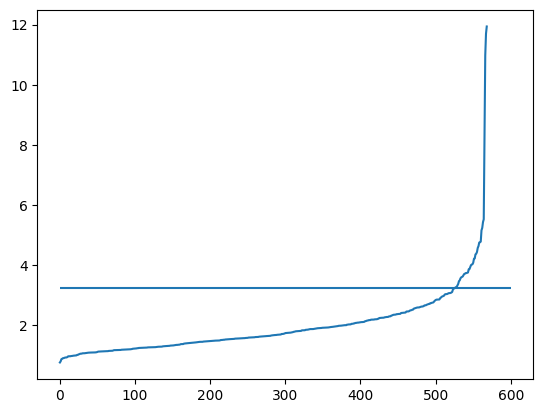

In [126]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=3.25, xmin=0, xmax=600)
# best eps around 2.5 for a cutoff on mutual info of .1
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 24


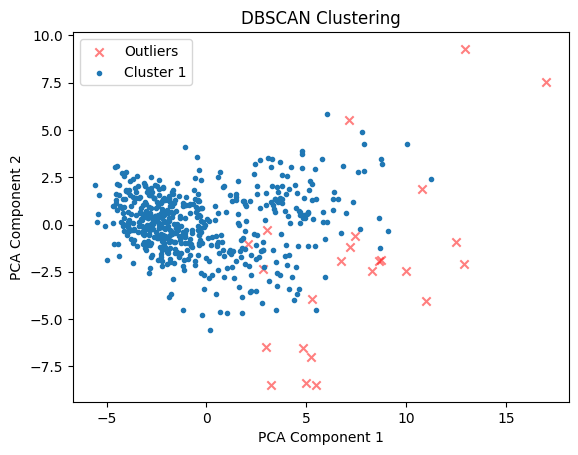

In [127]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3.25, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

inliersX = X.loc[labels == 0]
outliersX = X.loc[labels == -1]

inliersY = Y.loc[labels == 0]
outliersY = Y.loc[labels == -1]


plt.scatter(processed_data.loc[labels == -1, 0], processed_data.loc[labels == -1, 1], 
                    c='red', marker='x', label='Outliers', alpha=0.5)
plt.scatter(processed_data.loc[labels == 0, 0], processed_data.loc[labels == 0, 1], 
                    marker='.', label=f'Cluster 1')

#print(outliersDB)



        

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


K means clustering accuracy when including outliers 0.9244288224956063
K means clustering accuracy when excluding outliers 0.9357798165137615


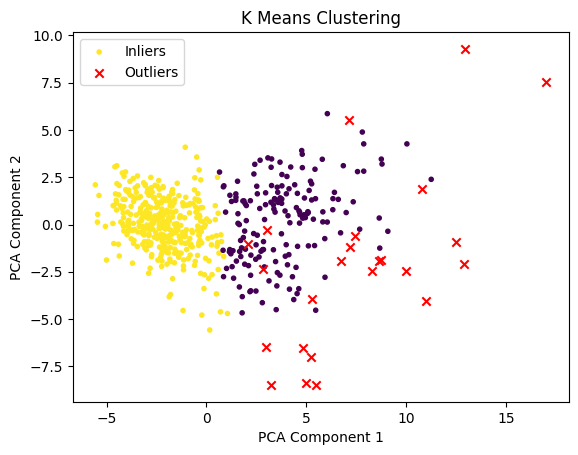

In [128]:
from sklearn.cluster import KMeans




inliers = processed_data[labels == 0]
outliers = processed_data[labels == -1]

# Perform KMeans clustering on the original scaled data
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(processed_data)
klabels_with_outliers = kmeans.labels_
kmeans.fit(inliers)
klabels = kmeans.labels_

k_means_accuracy = max((inliersY == klabels).sum()/(inliersY == klabels).count(), 
                            (inliersY == klabels^1).sum()/(inliersY == klabels^1).count())
k_means_accuracy_wo = max((Y == klabels_with_outliers^1).sum()/(Y == klabels_with_outliers^1).count(),
                            (Y == klabels_with_outliers).sum()/(Y == klabels_with_outliers).count())





print("K means clustering accuracy when including outliers",k_means_accuracy_wo)
print("K means clustering accuracy when excluding outliers",k_means_accuracy)


plt.scatter(inliers.iloc[:,0], inliers.iloc[:,1], c=klabels,marker='.', label='Inliers')
plt.scatter(outliers.iloc[:,0], outliers.iloc[:,1], c='red', marker='x', label='Outliers')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K Means Clustering')
plt.legend()
plt.show()


In [129]:
X = inliersX
Y = inliersY

In [130]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [131]:
outputs = []


In [132]:


#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,3,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Chosen max_depth: 32
Chosen min_samples_leaf: 1
Chosen max_depth: 35
Chosen min_samples_leaf: 1
Chosen max_depth: 35
Chosen min_samples_leaf: 1
Chosen max_depth: 34
Chosen min_samples_leaf: 1
Chosen max_depth: 33
Chosen min_samples_leaf: 1


In [133]:
#ADA Boosting
param_grid = {
   #'n_estimators': list(range(100,150,10)),
   'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Chosen n_estimators: 130
Chosen n_estimators: 110
Chosen n_estimators: 120
Chosen n_estimators: 110
Chosen n_estimators: 140


In [134]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': list(range(5, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


Chosen n_components: 8
Chosen kernel: linear
Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 10
Chosen kernel: rbf
Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 10
Chosen kernel: linear


In [135]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': list(range(5,10)),
    'knn__n_neighbors': list(range(2,4))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



Chosen n_components: 8
Chosen n_neighbors: 3
Chosen n_components: 7
Chosen n_neighbors: 3
Chosen n_components: 9
Chosen n_neighbors: 3
Chosen n_components: 8
Chosen n_neighbors: 3
Chosen n_components: 7
Chosen n_neighbors: 3


In [136]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,)],
    "nn__activation": ["tanh",],
    "nn__max_iter" : [200,250,300,350,400]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 350
Chosen hidden_layer_sizes: (50,)
Chosen activation: tanh
Chosen max_iter: 250
Chosen hidden_layer_sizes: (40,)
Chosen activation: tanh
Chosen max_iter: 400
Chosen hidden_layer_sizes: (30,)
Chosen activation: tanh
Chosen max_iter: 200
Chosen hidden_layer_sizes: (30,)
Chosen activation: tanh
Chosen max_iter: 350


In [137]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

Metrics for Random Forest
Accuracy: 0.963302752293578


,Predicted 1,Predicted 0
Actual 1,344,9
Actual 0,11,181


Precision:  0.9690140845070423
Recall: 0.9745042492917847

Metrics for ADA Boosting
Accuracy: 0.9688073394495413


,Predicted 1,Predicted 0
Actual 1,347,6
Actual 0,11,181


Precision:  0.9692737430167597
Recall: 0.9830028328611898

Metrics for SVM
Accuracy: 0.98348623853211


,Predicted 1,Predicted 0
Actual 1,350,3
Actual 0,6,186


Precision:  0.9831460674157303
Recall: 0.9915014164305949

Metrics for K Nearest Neighbor
Accuracy: 0.9614678899082569


,Predicted 1,Predicted 0
Actual 1,346,7
Actual 0,14,178


Precision:  0.9611111111111111
Recall: 0.9801699716713881

Metrics for Neural Nets
Accuracy: 0.9761467889908257


,Predicted 1,Predicted 0
Actual 1,347,6
Actual 0,7,185


Precision:  0.980225988700565
Recall: 0.9830028328611898



In [138]:
## save model here?